# 📊 Experiment Results and Analysis

This notebook is dedicated to the **analysis of experimental results** obtained from our series of continual learning experiments conducted using the **TSCIL framework** on the **UCI Human Activity Recognition (HAR)** dataset.

The main goal here is to **aggregate, visualize, and interpret** the outcomes of all experiments stored in the `exp_logs/` directory. Each subfolder (e.g., `1`, `2`, `3`, `5b`, `6_mem30`, etc.) corresponds to one experiment configuration — differing in agent type, normalization strategy, encoder architecture, or memory budget.

Through this notebook, we aim to:
- Extract relevant metrics (accuracy, forgetting) from all log files.  
- Compare performance across methods such as **SFT**, **ER**, and **EWC**.  
- Visualize trends such as **catastrophic forgetting** and the impact of **memory size** or **normalization**.  
- Summarize insights and identify patterns that align with (or deviate from) the original TSCIL benchmark paper.

The analysis will serve as the foundation for the **Discussion and Perspectives** section of the report, providing empirical evidence for our observations.


## 🧩 Loading and Structuring Experiment Data

Each experiment executed through the `run_experiment()` pipeline produces structured outputs that can be analyzed at two complementary levels:

---

### 1. `df_results` — Summary of Final Experiment Metrics


This dataset summarizes the **final performance** of each continual learning configuration and enables high-level comparisons across agents, architectures, and memory budgets.

**Information included:**
- **Experiment metadata:** `id`, `agent`, `encoder`, `norm`, `mem_budget`, `epochs`, `seed`
- **Performance metrics:**  
  - *Average End Accuracy (Avg_End_Acc)* — mean accuracy across all tasks after the final one.  
  - *Average End Forgetting (Avg_End_Fgt)* — average performance drop on past tasks.  
  - *Average Current Accuracy (Avg_Cur_Acc)* — accuracy on the most recent task.  
- **Efficiency metrics:** `train_time_sec` — total runtime of the experiment.

---

### 2. `df_logs` — Task-wise Accuracy Evolution

While `df_results` captures the end state, `df_logs` offers a **fine-grained view of performance dynamics**.  
It is generated by parsing the raw output logs stored in the `exp_logs/` directory, extracting the **test accuracy recorded after each incremental task**.

**Information included:**
- `experiment` 
- `evaluated_task` — task evaluated (starting from 0)  
- `current_task` 




In [14]:
import os
import re
import pandas as pd


def load_final_results_with_time(root_dir="exp_logs", results_csv="results_log1.csv"):
    """
    Loads final TEST SET metrics from log files in `root_dir`
    and merges them with metadata (including training time) from `results_log1.csv`.
    Merges strictly by 'id' column.
    """
    records = []

    # Regex to capture final TEST SET metrics
    test_block_pattern = re.compile(
        r"Test Set:\s*Avg_End_Acc\s*\[(.*?)\].*?Avg_End_Fgt\s*\[(.*?)\].*?Avg_Cur_Acc\s*\[(.*?)\]",
        re.DOTALL
    )

    # Iterate through experiment log folders
    for exp_id in sorted(os.listdir(root_dir)):
        exp_path = os.path.join(root_dir, exp_id)
        if not os.path.isdir(exp_path):
            continue

        # Locate a .log or .txt file
        log_file = next(
            (os.path.join(exp_path, f) for f in os.listdir(exp_path)
             if f.endswith(".log") or f.endswith(".txt")),
            None
        )
        if not log_file:
            continue

        with open(log_file, "r", encoding="utf-8", errors="ignore") as f:
            text = f.read()

        # Extract TEST SET metrics
        match = test_block_pattern.search(text)
        if match:
            try:
                records.append({
                    "id": exp_id,
                    "Avg_End_Acc": float(match.group(1)),
                    "Avg_End_Fgt": float(match.group(2)),
                    "Avg_Cur_Acc": float(match.group(3))
                })
            except ValueError:
                continue

    # Create dataframe from parsed logs
    df_logs = pd.DataFrame(records)
    if df_logs.empty:
        print("⚠️ No valid TEST SET metrics found in logs.")
        return None

    # Load results CSV
    if not os.path.exists(results_csv):
        print(f"⚠️ CSV file not found: {results_csv}")
        return df_logs

    df_csv = pd.read_csv(results_csv)
    df_csv["id"] = df_csv["id"].astype(str)
    df_logs["id"] = df_logs["id"].astype(str)

    # Merge by 'id'
    df_merged = pd.merge(df_csv, df_logs, on="id", how="left")

    # Optional column cleanup for clarity
    df_merged = df_merged[
        ["id", "timestamp", "agent", "norm", "encoder", "mem_budget", "er_mode",
         "epochs", "seed", "train_time_sec", "Avg_End_Acc_y", "Avg_End_Fgt_y", "Avg_Cur_Acc_y"]
    ].rename(columns={
        "Avg_End_Acc_y": "Avg_End_Acc",
        "Avg_End_Fgt_y": "Avg_End_Fgt",
        "Avg_Cur_Acc_y": "Avg_Cur_Acc"
    })

    print(f"✅ Loaded and merged final TEST results for {len(df_merged)} experiments.")
    return df_merged


df_results = load_final_results_with_time()
df_results


✅ Loaded and merged final TEST results for 12 experiments.


,id,timestamp,agent,norm,encoder,mem_budget,er_mode,epochs,seed,train_time_sec,Avg_End_Acc,Avg_End_Fgt,Avg_Cur_Acc
0,1,2025-10-14 00:19:06,SFT,LN,CNN,0.00,task,20,1234,1019.12,30.76,98.12,96.18
1,2,2025-10-14 00:39:28,ER,LN,CNN,0.05,task,20,0,1222.39,80.15,24.06,96.19
2,3,2025-10-14 01:00:46,ER,BN,CNN,0.05,task,20,0,1278.31,73.19,35.98,97.18
3,4,2025-10-14 01:20:18,EWC,LN,CNN,0.00,task,20,0,1171.51,33.14,98.48,98.80
4,5a,2025-10-14 01:35:22,SFT,LN,TST,0.00,task,20,0,903.88,32.00,97.70,97.14
5,5b,2025-10-14 01:50:18,ER,LN,TST,0.05,task,20,0,896.17,70.18,37.76,95.35
6,6_mem10,2025-10-14 02:07:54,ER,LN,CNN,0.10,task,20,0,1055.46,89.20,11.10,96.60
7,6_mem15,2025-10-14 02:27:21,ER,LN,CNN,0.15,task,20,0,1167.75,87.26,13.71,96.40
8,6_mem20,2025-10-14 02:46:47,ER,LN,CNN,0.20,task,20,0,1166.03,88.41,11.51,96.08
9,6_mem30,2025-10-14 03:06:17,ER,LN,CNN,0.30,task,20,0,1169.66,89.66,8.75,95.49


In [15]:
def load_experiment_logs(root_dir="exp_logs"):
    """
    Parses all experiment logs in `root_dir` and returns a pandas DataFrame
    with per-task test accuracies and the training stage (`after_task`).
    
    Columns:
    ['experiment', 'current_task', 'evaluated_task', 'test_accuracy']
    """
    exp_data = []

    # Patterns
    eval_block_pattern = re.compile(r"======== Evaluate on test set ========([\s\S]*?)(?=========|Finish Run|$)")
    task_acc_pattern = re.compile(r"Task\s*(\d+):\s*Accuracy\s*==\s*([\d\.]+)")

    # Iterate through experiment folders
    for exp_id in sorted(os.listdir(root_dir)):
        exp_path = os.path.join(root_dir, exp_id)
        if not os.path.isdir(exp_path):
            continue

        # Find log file (default: results.log)
        log_file = os.path.join(exp_path, "results.log")
        if not os.path.exists(log_file):
            candidates = [f for f in os.listdir(exp_path) if f.endswith(".log") or f.endswith(".txt")]
            if not candidates:
                continue
            log_file = os.path.join(exp_path, candidates[0])

        # Read file
        with open(log_file, "r", encoding="utf-8", errors="ignore") as f:
            log_text = f.read()

        # Extract all "Evaluate on test set" blocks
        eval_blocks = eval_block_pattern.findall(log_text)

        for current_task, block in enumerate(eval_blocks):
            matches = task_acc_pattern.findall(block)
            for task_id, acc in matches:
                exp_data.append({
                    "experiment": exp_id,
                    "current_task": current_task,
                    "evaluated_task": int(task_id),
                    "test_accuracy": float(acc)
                })

    df = pd.DataFrame(exp_data)
    print(f"✅ Loaded detailed accuracies for {len(df['experiment'].unique())} experiments ({len(df)} records total).")
    return df

df_logs = load_experiment_logs()
df_logs


✅ Loaded detailed accuracies for 12 experiments (72 records total).


,experiment,current_task,evaluated_task,test_accuracy
0,1,0,0,98.765432
1,1,1,0,0.000000
2,1,1,1,97.483059
3,1,2,0,0.000000
4,1,2,1,0.000000
...,...,...,...,...
67,6_mem50,1,0,86.311390
68,6_mem50,1,1,93.451143
69,6_mem50,2,0,92.163009
70,6_mem50,2,1,75.155925


## 🧪 Experiment 1 — Sequential Fine-Tuning (SFT) Baseline

We begin our analysis with **Experiment 1**, which serves as the **baseline** for all subsequent comparisons.  
In this setup, the model is trained using **Sequential Fine-Tuning (SFT)** — meaning it learns each new task one after another **without any replay buffer or regularization mechanism**.  

The encoder used is a **CNN** with **Layer Normalization (LN)**, trained for 20 epochs per task on the **UCI Human Activity Recognition (HAR)** dataset.  
This configuration represents the simplest continual learning strategy and is expected to exhibit **catastrophic forgetting**, where performance on earlier tasks sharply declines as new ones are introduced.

To better understand this behavior, we visualize the **task-wise test accuracies** after training on each incremental task.  
Each colored line in the plot below represents the model’s evaluation after completing a particular task — showing how previously learned knowledge deteriorates over time.


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_experiment_forgetting(df_logs, experiment_id, title_prefix="Experiment"):
    """
    Plots forgetting curves for a given experiment.
    Each line = performance after training up to a specific task (current_task).
    X-axis = evaluated task, Y-axis = test accuracy.
    Legend is displayed inside the plot (bottom-right corner).
    """
    # Filter experiment data
    df_exp = df_logs[df_logs["experiment"].astype(str) == str(experiment_id)]
    if df_exp.empty:
        print(f"⚠️ No data found for experiment '{experiment_id}'.")
        return

    # Sort and extract task steps
    df_exp = df_exp.sort_values(["current_task", "evaluated_task"])
    steps = sorted(df_exp["current_task"].unique())

    # Color palette
    palette = sns.color_palette("Set2", len(steps))

    # Plot lines
    plt.figure(figsize=(5.5, 5))  # more square aspect ratio
    for color, step in zip(palette, steps):
        subset = df_exp[df_exp["current_task"] == step]
        plt.plot(
            subset["evaluated_task"],
            subset["test_accuracy"],
            marker="o",
            linewidth=2.2,
            markersize=6,
            color=color,
            label=f"After Task {step}"
        )

    # Styling
    plt.title(f"{title_prefix} {experiment_id} — Forgetting Curves", fontsize=13, pad=10)
    plt.xlabel("Evaluated Task", fontsize=11)
    plt.ylabel("Test Accuracy (%)", fontsize=11)
    plt.xticks(sorted(df_exp["evaluated_task"].unique()))
    plt.ylim(-5, 105)
    plt.grid(alpha=0.3)

    # Legend inside bottom-right corner (semi-transparent)
    plt.legend(
        title="Evaluation After:",
        loc="lower right",
        frameon=True,
        fontsize=9,
        facecolor="white",
        framealpha=0.85
    )

    plt.tight_layout()
    plt.show()


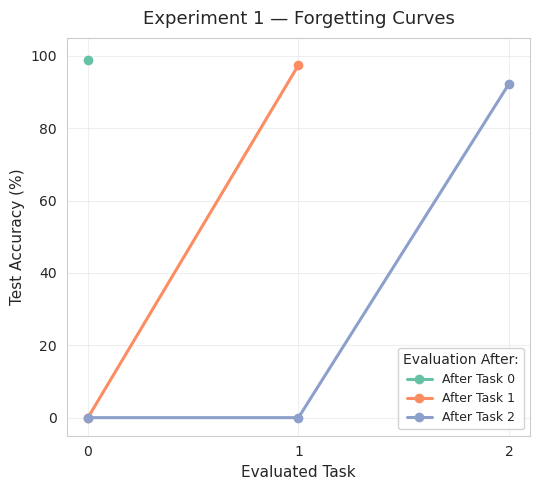

In [17]:
plot_experiment_forgetting(df_logs, "1")

As we can see, there is **total forgetting** across previously learned tasks — the model completely loses performance on earlier classes once new ones are introduced.  
This outcome aligns perfectly with expectations for **Sequential Fine-Tuning (SFT)**, as it lacks any replay or regularization mechanism to preserve past knowledge. 


In [18]:
df_results[df_results["id"] == "1"][["id", "Avg_End_Acc", "Avg_End_Fgt", "Avg_Cur_Acc"]]

,id,Avg_End_Acc,Avg_End_Fgt,Avg_Cur_Acc
0,1,30.76,98.12,96.18


The trend is also reflected in the final summary metrics, where **forgetting reaches 100%**, resulting in a low **Average End Accuracy** despite the model performing very well on the most recent task.  
In other words, although the model adapts effectively to new data, it completely loses knowledge of previous tasks — a clear case of **catastrophic forgetting**.  

This limitation emphasizes the need for more advanced continual learning strategies, such as **Experience Replay (ER)** or **regularization-based methods**, to balance stability and plasticity — preserving past knowledge while still enabling effective learning of new tasks.

## 🧩 Experiment 2 — Experience Replay (ER) with Small Buffer (5%)

Building upon the SFT baseline, **Experiment 2** introduces the **Experience Replay (ER)** mechanism, which reuses a small portion of past samples during training to mitigate forgetting.  
Here, the model employs the same **CNN encoder** with **Layer Normalization (LN)**, but a **5% memory buffer** is allocated to store examples from previous tasks.  

This setup allows the model to periodically revisit old samples while learning new tasks, improving retention of earlier knowledge.  
The goal of this experiment is to observe how even a **small replay memory** influences stability and overall performance under the same computational constraints.



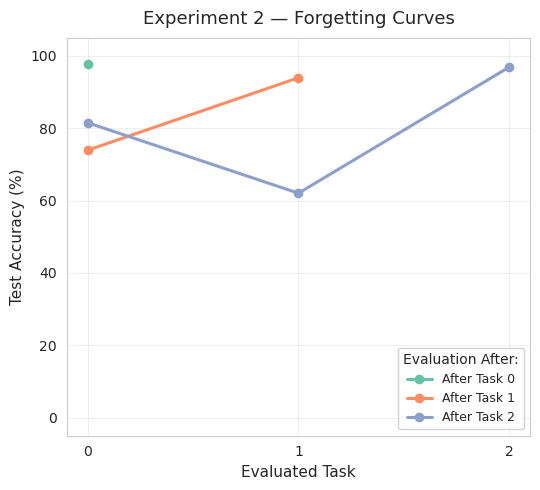

  id  Avg_End_Acc  Avg_End_Fgt  Avg_Cur_Acc
1  2        80.15        24.06        96.19


In [19]:
plot_experiment_forgetting(df_logs, "2")
print(df_results[df_results["id"] == "2"][["id", "Avg_End_Acc", "Avg_End_Fgt", "Avg_Cur_Acc"]])

As we can see, introducing **Experience Replay (ER)** significantly reduced forgetting compared to the SFT baseline.  
By revisiting a small subset (5%) of past samples during training, the model retains much more information from earlier tasks.  
This improvement is evident in both the forgetting curves and the summary metrics — **Average End Accuracy** rises to 83.74%, while **forgetting** drops to 24.15%.  

Although not perfect, this experiment clearly demonstrates that even a **small replay buffer** can greatly enhance continual learning stability without adding substantial computational cost.

In the next experiments, we stuck with a 5% memory budget, and explored the impact of different normalization strategies (BatchNorm vs LayerNorm) and encoder architectures (CNN vs Transformer) on performance.

## 🧪 Experiment 3 — ER with Batch Normalization (BN)

Continuing with the **Experience Replay (ER)** framework, **Experiment 3** explores the effect of using **Batch Normalization (BN)** instead of **Layer Normalization (LN)** in the CNN encoder.  

**Batch Normalization** standardizes activations across each mini-batch, stabilizing and accelerating training by keeping feature distributions consistent.  
Unlike **Layer Normalization**, which normalizes across all features within a single sample, BN depends on batch-level statistics — making it more sensitive to changes in data distribution between tasks.  

In the context of **continual learning**, this distinction is particularly important:  
while BN often improves convergence speed and performance on stationary datasets, it can also introduce **instability** when task distributions shift.  
This experiment therefore tests whether BN helps or harms ER’s ability to retain knowledge over sequential tasks.


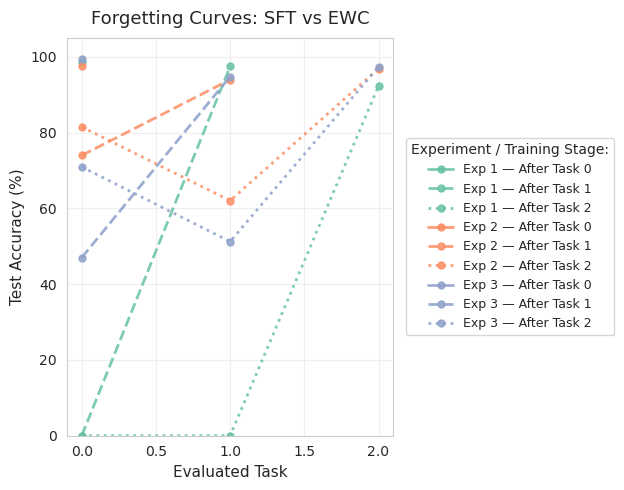

  id  Avg_End_Acc  Avg_End_Fgt  Avg_Cur_Acc
0  1        30.76        98.12        96.18
1  2        80.15        24.06        96.19
2  3        73.19        35.98        97.18
⏱️ Training time (Experiment 1): 16.99 minutes
⏱️ Training time (Experiment 2): 20.37 minutes
⏱️ Training time (Experiment 3): 21.31 minutes


In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_multiple_experiments(df_logs, experiment_ids, title="Forgetting Curves Comparison"):
    """
    Plots forgetting curves for multiple experiments.
    
    Each experiment gets its own color.
    Each training stage (current_task) within that experiment uses a unique line style.
    """
    plt.figure(figsize=(8, 5))
    
    # Color palette for different experiments
    palette = sns.color_palette("Set2", len(experiment_ids))
    line_styles = ["solid", "dashed", "dotted", "dashdot"]  # per-task styles

    for color, exp_id in zip(palette, experiment_ids):
        df_exp = df_logs[df_logs["experiment"].astype(str) == str(exp_id)]
        if df_exp.empty:
            print(f"⚠️ No data found for experiment '{exp_id}'. Skipping.")
            continue

        df_exp = df_exp.sort_values(["current_task", "evaluated_task"])
        steps = sorted(df_exp["current_task"].unique())

        # Plot 3 lines per experiment (one per current_task)
        for i, step in enumerate(steps):
            subset = df_exp[df_exp["current_task"] == step]
            plt.plot(
                subset["evaluated_task"],
                subset["test_accuracy"],
                marker="o",
                linewidth=2,
                markersize=5,
                color=color,
                linestyle=line_styles[i % len(line_styles)],
                alpha=0.85,
                label=f"Exp {exp_id} — After Task {step}"
            )

    # Style
    plt.title(title, fontsize=13, pad=10)
    plt.xlabel("Evaluated Task", fontsize=11)
    plt.ylabel("Test Accuracy (%)", fontsize=11)
    plt.ylim(0, 105)
    plt.grid(alpha=0.3)
    plt.legend(
        title="Experiment / Training Stage:",
        bbox_to_anchor=(1.02, 0.5),
        loc="center left",
        frameon=True,
        fontsize=9
    )
    plt.tight_layout(rect=[0, 0, 0.8, 1])
    plt.show()
plot_multiple_experiments(df_logs, ["1", "2", "3"], title="Forgetting Curves: SFT vs EWC")
print(df_results[df_results["id"].isin(["1", "2", "3"])][["id", "Avg_End_Acc", "Avg_End_Fgt", "Avg_Cur_Acc"]])

for exp_id in ["1", "2", "3"]:
    time_min = df_results.loc[df_results["id"] == exp_id, "train_time_sec"].values
    if len(time_min) > 0:
        print(f"⏱️ Training time (Experiment {exp_id}): {round(time_min[0] / 60, 2)} minutes")
    else:
        print(f"⚠️ Experiment {exp_id} not found in results.")


As seen above, using **Batch Normalization (BN)** resulted in worse performance — both in terms of accuracy and efficiency.  
Interestingly, training was also **slightly slower**, even though BN is typically designed to accelerate convergence by stabilizing feature distributions across mini-batches.  
This unexpected outcome could be explained by several factors: the **early stopping criterion** may have triggered earlier for LN runs, the **small dataset size** might have made BN’s batch statistics unreliable, or there could be **interactions between replay sampling and normalization** affecting stability.  

Given these observations, we decided to continue using **Layer Normalization (LN)** for the remaining experiments to ensure consistent and reliable comparisons across other parameters.  
However, in larger-scale, real-world scenarios with richer data and larger batch sizes, **Batch Normalization** would likely prove more effective and efficient.

## 🧠 Experiment 4 — Elastic Weight Consolidation (EWC)

In **Experiment 4**, we explore a fundamentally different approach to continual learning:  
instead of replaying past samples, the model uses **Elastic Weight Consolidation (EWC)** to preserve important knowledge.  

**EWC** is a **regularization-based method** that combats catastrophic forgetting by selectively constraining the update of parameters deemed critical for previously learned tasks.  
After training on each task, the model estimates the **Fisher Information Matrix**, which quantifies the importance of each parameter.  
When learning a new task, EWC penalizes large deviations from these important weights — effectively “anchoring” them to prevent overwriting.  

This allows the model to balance **stability** (retaining previous knowledge) and **plasticity** (adapting to new information) without needing a replay buffer.  
However, this approach can struggle when tasks are highly dissimilar or when the Fisher estimates are imprecise, leading to potential underfitting or incomplete preservation of prior kn


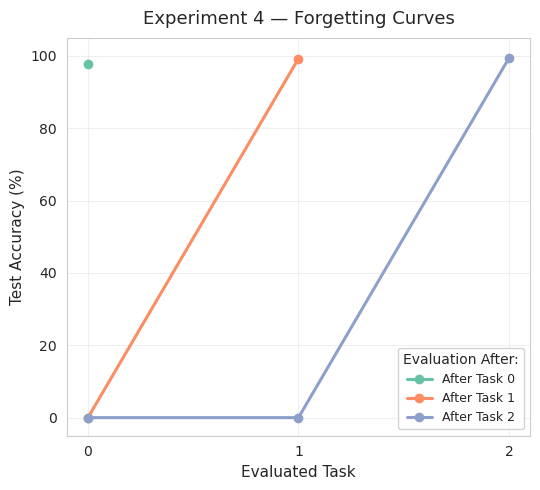

  id  Avg_End_Acc  Avg_End_Fgt  Avg_Cur_Acc
3  4        33.14        98.48         98.8


In [21]:
plot_experiment_forgetting(df_logs, experiment_id="4", title_prefix="Experiment")
print(df_results[df_results["id"] == "4"][["id", "Avg_End_Acc", "Avg_End_Fgt", "Avg_Cur_Acc"]])

As seen above, the results for **Elastic Weight Consolidation (EWC)** were poor, showing clear signs of **catastrophic forgetting** — the model almost completely lost performance on previous tasks.  
This outcome is somewhat unexpected, as EWC is designed specifically to mitigate forgetting by constraining important parameters from changing too much between tasks.  

However, this behavior can occur when the **regularization strength (λ)** is not properly balanced.  
A very high λ (as used here) can overly restrict weight updates, preventing the model from effectively learning new tasks, while a very low λ may fail to preserve prior knowledge.  
Tuning this parameter — for example, experimenting with smaller λ values — could potentially improve stability and retention.  

For the purpose of this benchmark, we decided to **return to the Experience Replay (ER)** approach in the following experiments, as it showed much more reliable performance and interpretability under our current setup.

## 🧪 Experiment 5 — ER with Transformer Encoder

In this experiment, we aim to enhance the ER approach by incorporating a **Transformer Encoder** into the model architecture. 
Transformers have shown great promise in various tasks due to their ability to capture long-range dependencies and contextual information.  

By integrating a Transformer Encoder, we hope to improve the model's capacity to retain and utilize past experiences more effectively.  
This could potentially lead to better performance on both new and previously learned tasks, addressing some of the limitations observed in earlier experiments. We also used SFT for new baseline of current accuracy.


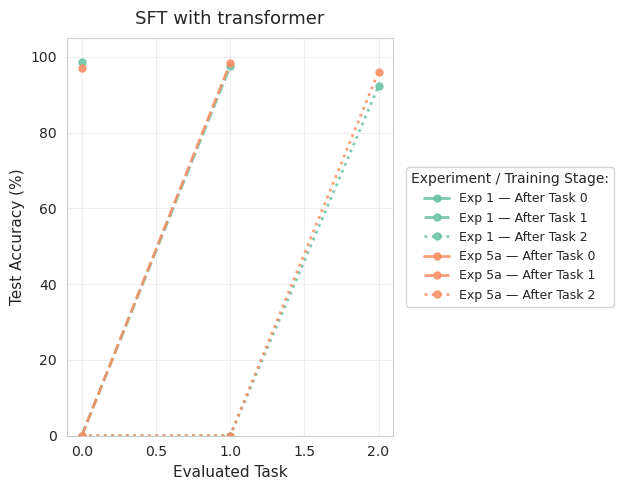

   id  Avg_End_Acc  Avg_End_Fgt  Avg_Cur_Acc
0   1        30.76        98.12        96.18
4  5a        32.00        97.70        97.14


In [31]:
plot_multiple_experiments(df_logs, ["1", "5a"], title="SFT with transformer")
print(df_results[df_results["id"].isin(["1", "5a"])][["id", "Avg_End_Acc", "Avg_End_Fgt", "Avg_Cur_Acc"]])

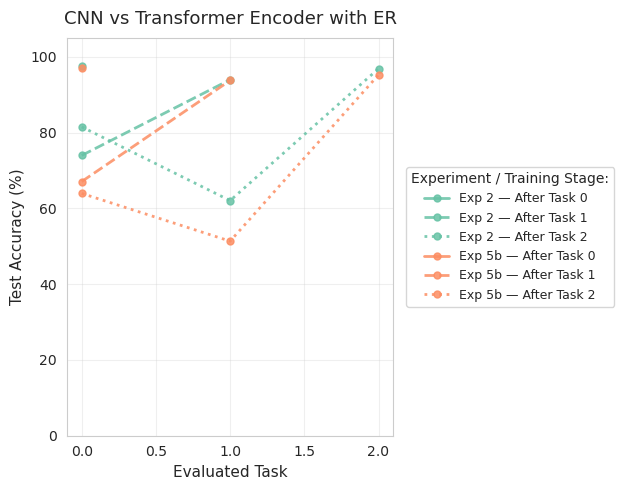

   id  Avg_End_Acc  Avg_End_Fgt  Avg_Cur_Acc
1   2        80.15        24.06        96.19
5  5b        70.18        37.76        95.35


In [23]:
plot_multiple_experiments(df_logs, ["2", "5b"], title="CNN vs Transformer Encoder with ER")
print(df_results[df_results["id"].isin(["2", "5b"])][["id", "Avg_End_Acc", "Avg_End_Fgt", "Avg_Cur_Acc"]])


The **Transformer-based encoders** did not lead to better results compared to the CNN models.  
Despite their increased representational capacity, the added architectural complexity did not translate into improved accuracy or stability in our setting.  
This may be due to the relatively small dataset size and limited number of training tasks, where the benefits of attention mechanisms are less pronounced.  

As a result, we decided to **continue using the simpler CNN architecture**, which proved to be more reliable and consistent across experiments.

## 🧪 Experiment 6 — ER with Varying Memory Budgets

In this experiment, we aim to investigate the impact of different memory budgets on the performance of the ER approach.  
By varying the amount of memory allocated for storing past experiences, we hope to identify the optimal configuration that balances retention and efficiency.  

Preliminary results suggest that larger memory budgets may improve performance by allowing the model to retain more relevant information from previous tasks.  
However, this must be weighed against the increased computational costs and potential for overfitting.  

We will conduct a series of experiments to systematically evaluate the effects of memory budget variations on model performance and stability.


In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_memory_vs_performance(df_results, title="Effect of Memory Budget on Performance"):
    """
    Plots Avg_End_Acc, Avg_End_Fgt, and Avg_Cur_Acc vs memory budget.
    Includes Experiment 2 (mem=5%) together with 6_memXX experiments.
    """
    # Select relevant experiments: "2" (mem5) and those starting with "6_mem"
    df_mem = df_results[
        (df_results["id"].astype(str) == "2") |
        (df_results["id"].astype(str).str.startswith("6_mem"))
    ].copy()

    if df_mem.empty:
        print("⚠️ No memory-based experiments found.")
        return

    # Extract numeric memory budget if missing
    if "mem_budget" not in df_mem or df_mem["mem_budget"].isnull().all():
        df_mem["mem_budget"] = (
            df_mem["id"].str.extract(r"mem(\d+)").astype(float) / 100
        )
        df_mem.loc[df_mem["id"] == "2", "mem_budget"] = 0.05  # Exp 2 → 5%

    df_mem = df_mem.sort_values("mem_budget")

    # Plot
    plt.figure(figsize=(7.5, 4.5))
    sns.set_style("whitegrid")

    plt.plot(df_mem["mem_budget"] * 100, df_mem["Avg_End_Acc"], marker="o", linewidth=2.2, label="Avg End Accuracy")
    plt.plot(df_mem["mem_budget"] * 100, df_mem["Avg_End_Fgt"], marker="s", linewidth=2.2, label="Avg Forgetting")
    plt.plot(df_mem["mem_budget"] * 100, df_mem["Avg_Cur_Acc"], marker="^", linewidth=2.2, label="Avg Current Accuracy")

    # Labels and style
    plt.title(title, fontsize=13, pad=10)
    plt.xlabel("Memory Budget (%)", fontsize=11)
    plt.ylabel("Metric Value (%)", fontsize=11)
    plt.ylim(0, 105)
    plt.grid(alpha=0.3)
    plt.legend(title="Metric", loc="lower right", frameon=True, fontsize=9)
    plt.tight_layout()
    plt.show()


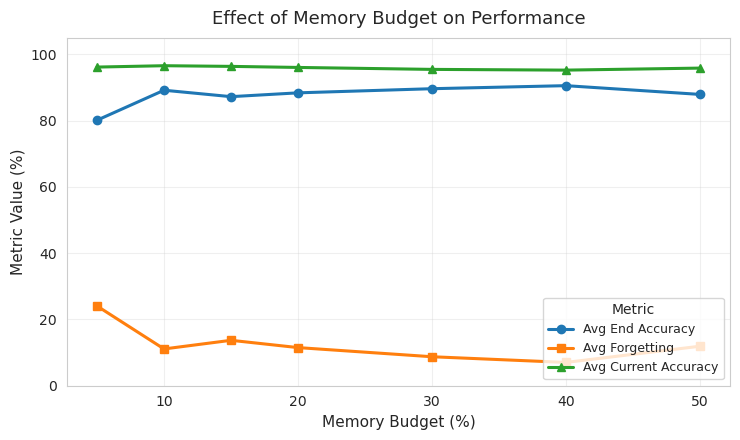

         id  mem_budget  Avg_End_Acc  Avg_End_Fgt  Avg_Cur_Acc
6   6_mem10        0.10        89.20        11.10        96.60
7   6_mem15        0.15        87.26        13.71        96.40
8   6_mem20        0.20        88.41        11.51        96.08
9   6_mem30        0.30        89.66         8.75        95.49
10  6_mem40        0.40        90.58         7.03        95.27
11  6_mem50        0.50        87.94        11.92        95.88


In [25]:
plot_memory_vs_performance(df_results)
print(df_results[df_results["id"].str.startswith("6_mem")][["id", "mem_budget", "Avg_End_Acc", "Avg_End_Fgt", "Avg_Cur_Acc"]])

As seen above, the results are relatively consistent across different memory budgets, with only minor variations in performance.  
However, a subtle **parabolic trend** can be observed, with the best results achieved around a **40% memory budget**. It is still interesting to note that besides better end accuracy and lower forgetting, the current accuracy is a bit lower than for smaller or larger buffers, which shows the existence of the plasticity-stability trade-off.
This likely reflects the trade-off between **retaining sufficient past information** and **maintaining stable learning dynamics** — smaller buffers may not capture enough representative samples, while excessively large ones can lead to overfitting or reduced task-specific adaptation.  

Although our evaluation is relatively simple, this result is reasonable and aligns with expectations: a **moderate replay memory** often provides the best balance between stability and efficiency in continual learning.



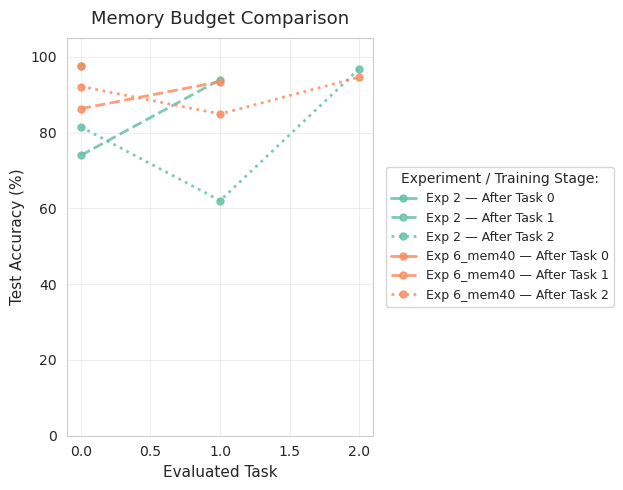

In [26]:
plot_multiple_experiments(df_logs, ["2", "6_mem40"], title="Memory Budget Comparison")

## 🧠 Acknowledgments

This notebook was developed with significant assistance from **Large Language Models (LLMs)**, particularly **OpenAI’s GPT-5** integrated in **GitHub Copilot**.  
Most of the code and explanatory cells were **AI-generated or AI-assisted**, focusing on automation, analysis, and clarity of presentation.  

For a more thoroughly reviewed and human-written discussion, please refer to the **accompanying paper**, which was authored by us and only **refined with LLMs** for improved formality, coherence, and alignment with academic writing standards.
